# Adam——从零开始

Adam是一个组合了动量法和RMSProp的优化算法 [1]。下面我们来介绍Adam算法。


## Adam算法

Adam算法使用了动量变量$\boldsymbol{v}$和RMSProp中小批量随机梯度按元素平方的指数加权移动平均变量$\boldsymbol{s}$，并将它们中每个元素初始化为0。在每次迭代中，首先计算小批量随机梯度$\boldsymbol{g}$，并递增迭代次数

$$t \leftarrow t + 1.$$


和动量法类似，给定超参数$\beta_1$且满足$0 \leq \beta_1 < 1$（算法作者建议设为0.9），将小批量随机梯度$\boldsymbol{g}$的指数加权移动平均记作动量变量$\boldsymbol{v}$:

$$\boldsymbol{v} \leftarrow \beta_1 \boldsymbol{v} + (1 - \beta_1) \boldsymbol{g}. $$

和RMSProp中一样，给定超参数$\beta_2$且满足$0 \leq \beta_2 < 1$（算法作者建议设为0.999），
将$\boldsymbol{g}$按元素平方后做指数加权移动平均得到$\boldsymbol{s}$：

$$\boldsymbol{s} \leftarrow \beta_2 \boldsymbol{s} + (1 - \beta_2) \boldsymbol{g} \odot \boldsymbol{g}. $$

我们在[动量法——从零开始](momentum-scratch.md)一节中解释了，$\boldsymbol{v}$和$\boldsymbol{s}$可分别看作是最近$1/(1 - \beta_1)$个时刻$\boldsymbol{g}$和最近$1 / (1 - \beta_2)$个时刻的$\boldsymbol{g} \odot \boldsymbol{g}$的加权平均。假设$\beta_1 = 0.9$，$\beta_2 = 0.999$，如果$\boldsymbol{v}$和$\boldsymbol{s}$中的元素都初始化为0，在时刻1我们得到$\boldsymbol{v} = 0.1\boldsymbol{g}$，$\boldsymbol{s} = 0.001\boldsymbol{g} \odot \boldsymbol{g}$。实际上，在迭代初期$t$较小时，$\boldsymbol{v}$和$\boldsymbol{s}$可能过小而无法较准确地估计$\boldsymbol{g}$和$\boldsymbol{g} \odot \boldsymbol{g}$。为此，Adam算法使用了偏差修正：

$$\hat{\boldsymbol{v}} \leftarrow \frac{\boldsymbol{v}}{1 - \beta_1^t}, $$

$$\hat{\boldsymbol{s}} \leftarrow \frac{\boldsymbol{s}}{1 - \beta_2^t}. $$

由于$0 \leq \beta_1, \beta_2 < 1$，在迭代初期$t$较小时，上面两式的分母较接近0，相当于放大了$\boldsymbol{v}$和$\boldsymbol{s}$的值。
当迭代后期$t$较大时，上面两式的分母较接近1，偏差修正就几乎不再有影响。

接下来，Adam算法使用以上偏差修正后的动量变量$\hat{\boldsymbol{v}}$和RMSProp中小批量随机梯度按元素平方的指数加权移动平均变量$\hat{\boldsymbol{s}}$，将模型参数中每个元素的学习率通过按元素运算重新调整：

$$\boldsymbol{g}^\prime \leftarrow \frac{\eta \hat{\boldsymbol{v}}}{\sqrt{\hat{\boldsymbol{s}} + \epsilon}},$$

其中$\eta$是初始学习率且$\eta > 0$，$\epsilon$是为了维持数值稳定性而添加的常数，例如$10^{-8}$。和Adagrad、RMSProp以及Adadelta一样，目标函数自变量中每个元素都分别拥有自己的学习率。

最后，自变量迭代步骤与小批量随机梯度下降类似：

$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \boldsymbol{g}^\prime. $$


## Adam的实现


Adam的实现很简单。我们只需要把上面的数学公式翻译成代码。

In [1]:
def adam(params, vs, sqrs, lr, batch_size, t):
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8
    for param, v, sqr in zip(params, vs, sqrs):      
        g = param.grad / batch_size
        v[:] = beta1 * v + (1 - beta1) * g
        sqr[:] = beta2 * sqr + (1 - beta2) * g.square()
        v_bias_corr = v / (1 - beta1 ** t)
        sqr_bias_corr = sqr / (1 - beta2 ** t)    
        param[:] = param - lr * v_bias_corr / (
            sqr_bias_corr.sqrt() + eps_stable)  

## 实验

首先，导入实验所需的包。

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import sys
import mxnet as mx
from mxnet import autograd, gluon, nd
import numpy as np
sys.path.append('..')
import utils

实验中，我们依然以线性回归为例。设数据集的样本数为1000，我们使用权重`w`为[2, -3.4]，偏差`b`为4.2的线性回归模型来生成数据集。该模型的平方损失函数即所需优化的目标函数，模型参数即目标函数自变量。

我们把算法中变量$\boldsymbol{v}$和$\boldsymbol{s}$初始化为和模型参数形状相同的零张量。

In [3]:
# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += 0.01 * nd.random.normal(scale=1, shape=y.shape)

# 初始化模型参数。
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    vs = []
    sqrs = []
    for param in params:
        param.attach_grad()
        # 把算法中基于指数加权移动平均的变量初始化为和参数形状相同的零张量。
        vs.append(param.zeros_like())
        sqrs.append(param.zeros_like())
    return params, vs, sqrs

优化函数`optimize`与[“Adagrad——从零开始”](adagrad-scratch.md)一节中的类似。

In [4]:
net = utils.linreg
squared_loss = utils.squared_loss

def optimize(batch_size, lr, num_epochs, log_interval):
    [w, b], vs, sqrs = init_params()
    y_vals = [squared_loss(net(X, w, b), y).mean().asnumpy()]
    t = 0
    for epoch in range(1, num_epochs + 1):
        for batch_i, (features, label) in enumerate(
            utils.data_iter(batch_size, num_examples, X, y)):
            with autograd.record():
                output = net(features, w, b)
                loss = squared_loss(output, label)
            loss.backward()
            # 必须在调用Adam前。
            t += 1
            adam([w, b], vs, sqrs, lr, batch_size, t)
            if batch_i * batch_size % log_interval == 0:
                y_vals.append(squared_loss(net(X, w, b), y).mean().asnumpy())
    print('w:', w, '\nb:', b, '\n')
    x_vals = np.linspace(0, num_epochs, len(y_vals), endpoint=True)
    utils.semilogy(x_vals, y_vals, 'epoch', 'loss')

最终，优化所得的模型参数值与它们的真实值较接近。

w: 
[[ 1.99847484]
 [-3.39840007]]
<NDArray 2x1 @cpu(0)> 
b: 
[ 4.20141077]
<NDArray 1 @cpu(0)> 



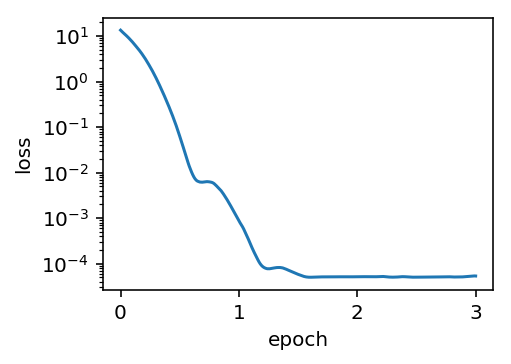

In [5]:
optimize(batch_size=10, lr=0.1, num_epochs=3, log_interval=10)

## 小结

* Adam组合了动量法和RMSProp。
* Adam使用了偏差修正。


## 练习

* 使用其他初始学习率，观察并分析实验结果。


## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/2279)


![](../img/qr_adam-scratch.svg)

## 参考文献

[1] Kingma, D. P., & Ba, J. (2014). Adam: A Method for Stochastic Optimization. arXiv preprint arXiv:1412.6980.